## Example notebook for inferring definitive endoderm differentiation trajectories

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from venn import venn
import scvelo as scv
import phate
import sys
sys.path.append('..')
import delve_benchmark

%load_ext autoreload
%autoreload 2

adata_directory = '../data/Zenodo' ## https://zenodo.org/records/10105826
adata = sc.read_h5ad(os.path.join(adata_directory, 'adata_DE.h5ad'))
adata.uns['log1p']["base"] = None #weird anndata saving thing

### Perform DELVE feature selection

In [2]:
n_selected = 500
k = 10
trial = 0

feature_directory = os.path.join('../data', 'DE', 'predicted_features_runner')
delve_benchmark.pp.make_directory(feature_directory)

## DELVE
fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.run_delve_fs, fs_method_params = {'num_subsamples': 1000, 'n_clusters': 5, 'k': k, 'n_random_state': 10, 'return_modules': True, 'random_state': 93})
delta_mean, modules, delve_genes = fs.select()
delve_genes.to_csv(os.path.join(feature_directory, f'delve_fs_trial{trial}.csv'))
delve_genes = delve_genes.index[:n_selected]
delta_mean.to_csv(os.path.join(feature_directory, f'delta_mean_trial{trial}.csv'))
modules.to_csv(os.path.join(feature_directory, f'modules_trial{trial}.csv'))

INFO:root:Step 1: identifying dynamic feature modules
INFO:root:estimating feature dynamics
performing subsampling: 100%|██████████| 1/1 [00:18<00:00, 18.50s/it]
clustering features and performing gene-wise permutation testing: 100%|██████████| 10/10 [02:46<00:00, 16.61s/it]
INFO:root:identified 2 dynamic cluster(s)
INFO:root:Step 2: performing feature selection


### Perform GO on DELVE dynamic modules

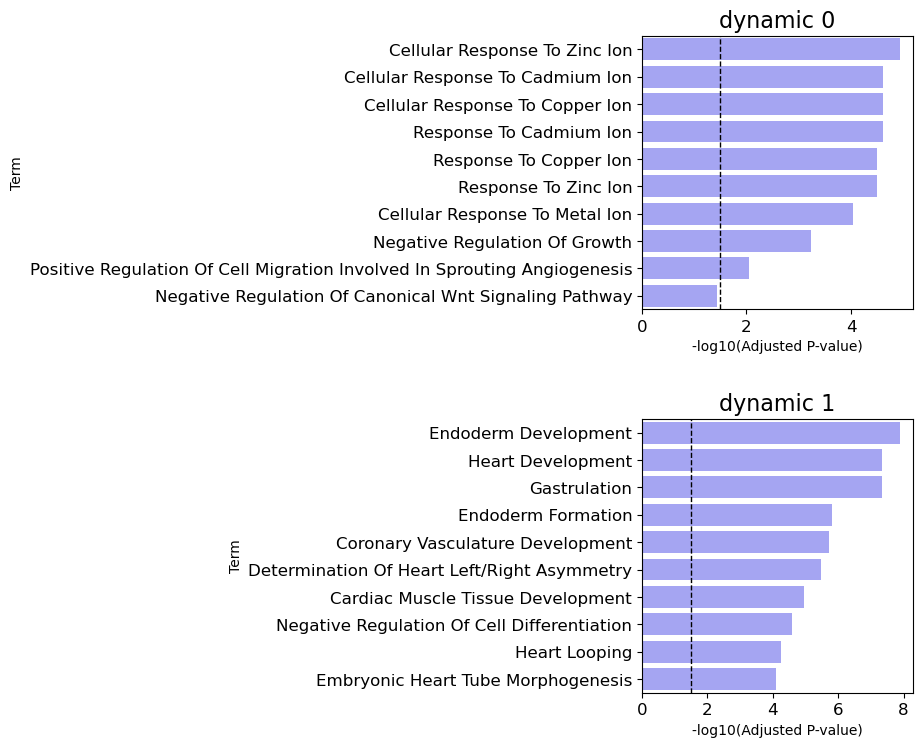

In [3]:
gene_sets = ['GO_Biological_Process_2023']
organism = 'human'
xlim = [0, 8]
n_select = 10

dyn_clusters = np.unique(modules[modules['cluster_id'] != 'static'])
sub_idx = len(dyn_clusters)
_, axes = plt.subplots(sub_idx, 1, figsize = (3.5, 4.5*sub_idx), gridspec_kw={'hspace': 0.4, 'wspace': 0.4, 'bottom':0.15})
for i, ax in zip(range(0, sub_idx), axes.flat):
    go =  delve_benchmark.tl.gene_ontology(gene_list = list(modules[modules['cluster_id'] == dyn_clusters[i]].index), gene_sets = gene_sets, organism = organism)
    df = go.loc[:, ['Term', 'Adjusted P-value']].copy()
    df = df.sort_values(by = 'Adjusted P-value', ascending=True)
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
    df['Term'] = [i.split(' (GO')[0] for i in df['Term']]
    g = sns.barplot(y = 'Term', x = '-log10(Adjusted P-value)', data = df, color = 'b', alpha = 0.4,
                    order = df.groupby('Term').mean().sort_values(by = '-log10(Adjusted P-value)', ascending=False).index[:n_select],
                    ci = 'sd', capsize = 0.3, errcolor = 'black', errwidth=1, ax = ax)
    g.tick_params(labelsize=12)
    g.set_title(dyn_clusters[i], fontsize = 16)
    g.axvline(1.5, color = 'k', ls = '--', lw = 1)

### Plot dynamic modules

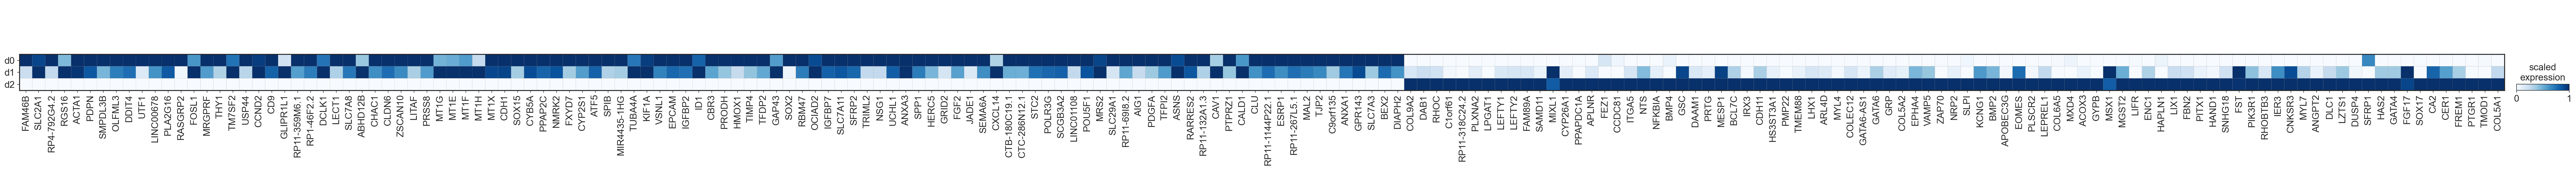

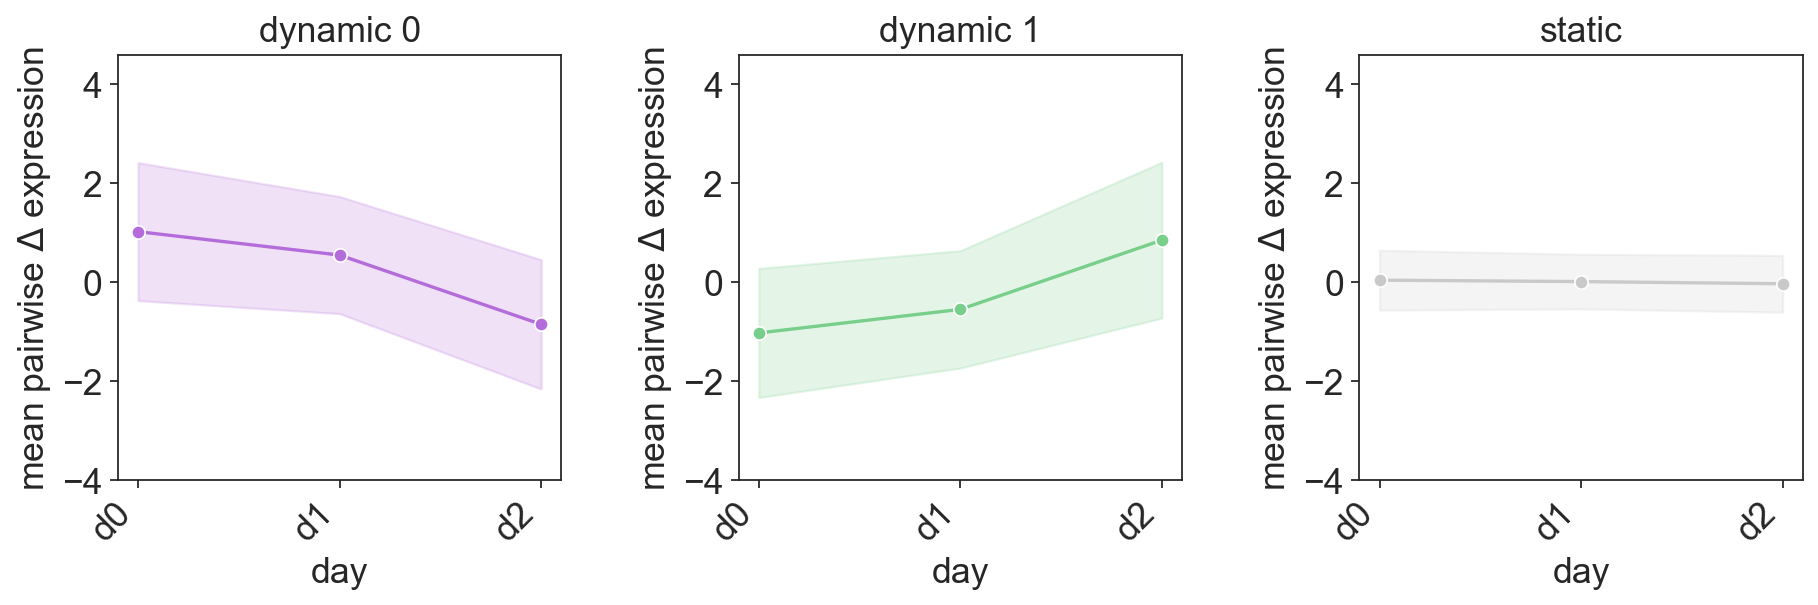

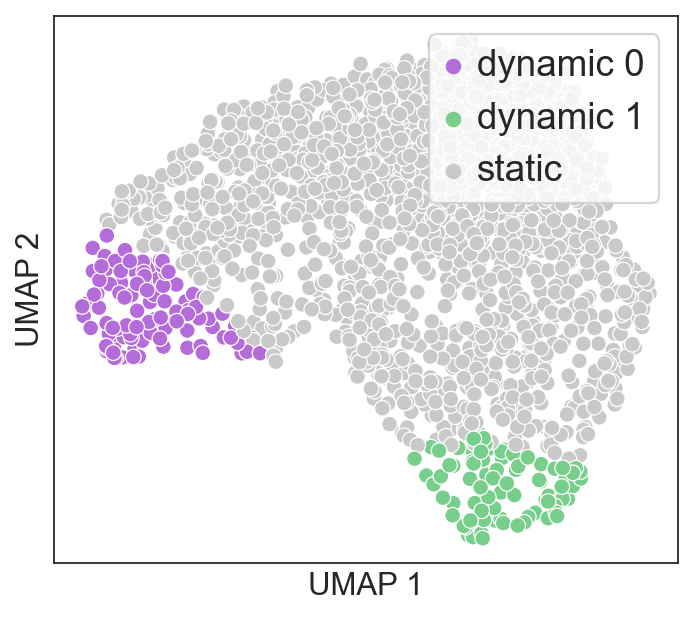

In [4]:
## plot seed dynamics
seed_directory = os.path.join('../figures', 'DE', 'seed_runner')
delve_benchmark.pl.plot_seed(adata_directory = adata_directory, feature_directory = feature_directory, adata_name = 'adata_DE', labels_key = 'day', m_order= ['d0', 'd1', 'd2'],
                            save_directory = seed_directory, filename_save = 'DE', trial = trial, ylim = [-4, 4.6])

### Assess the significance of dynamically expressed genes within DELVE modules using the [STRING](https://string-db.org/) database

#### Plot DELVE dynamic module association networks

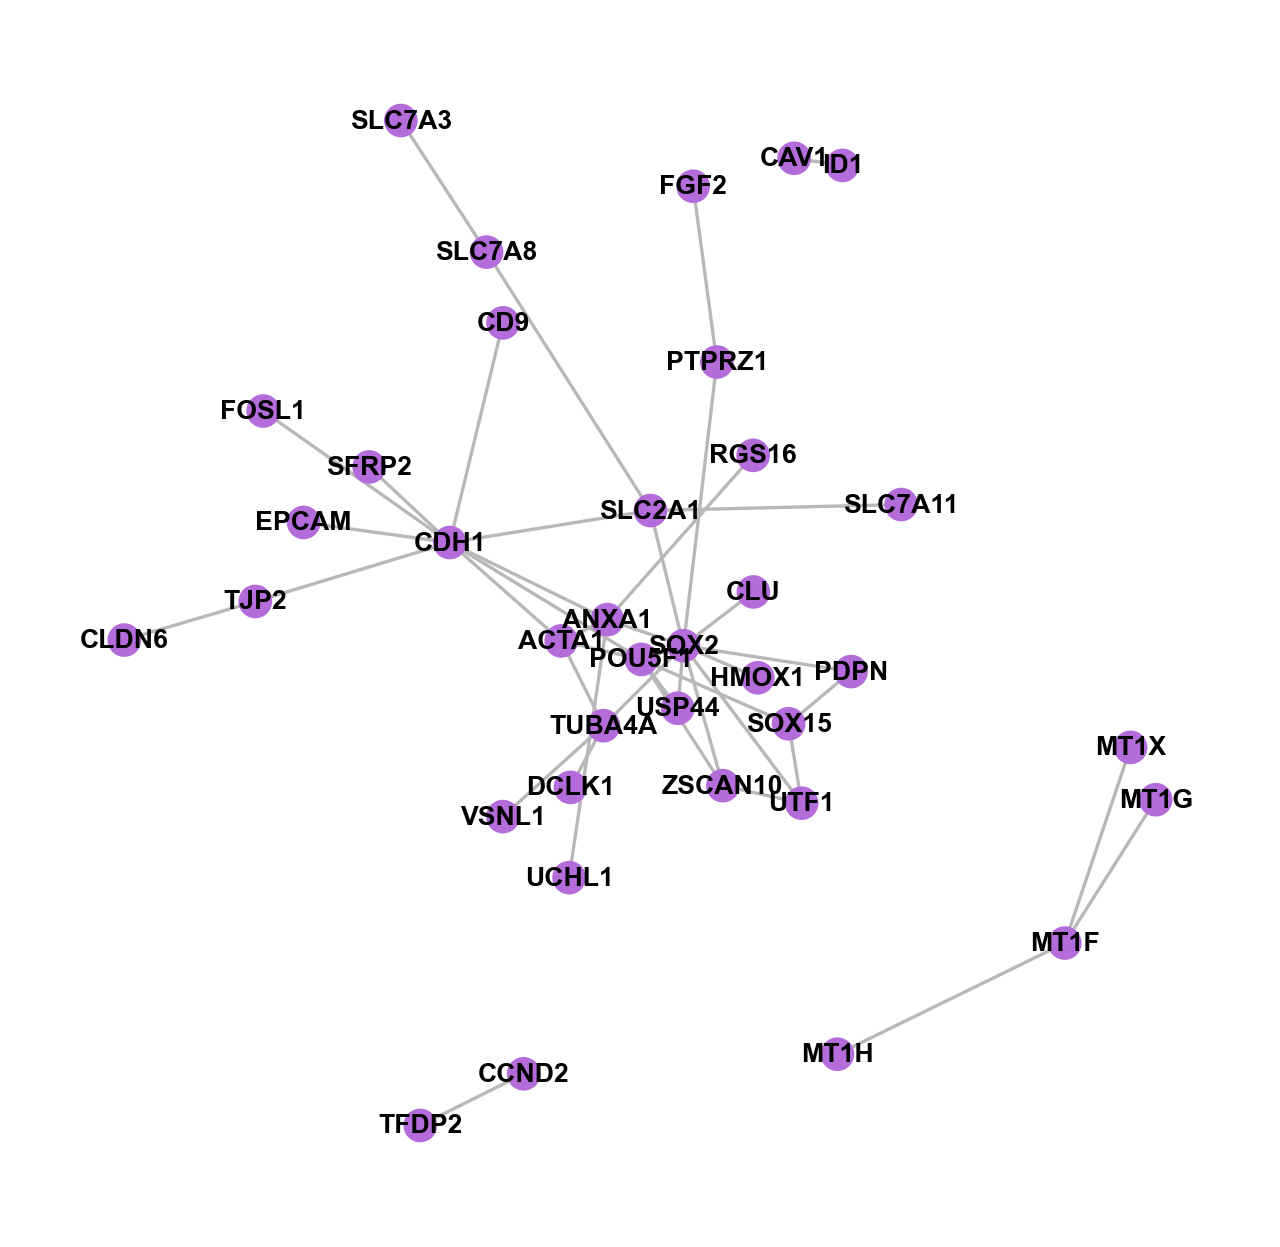

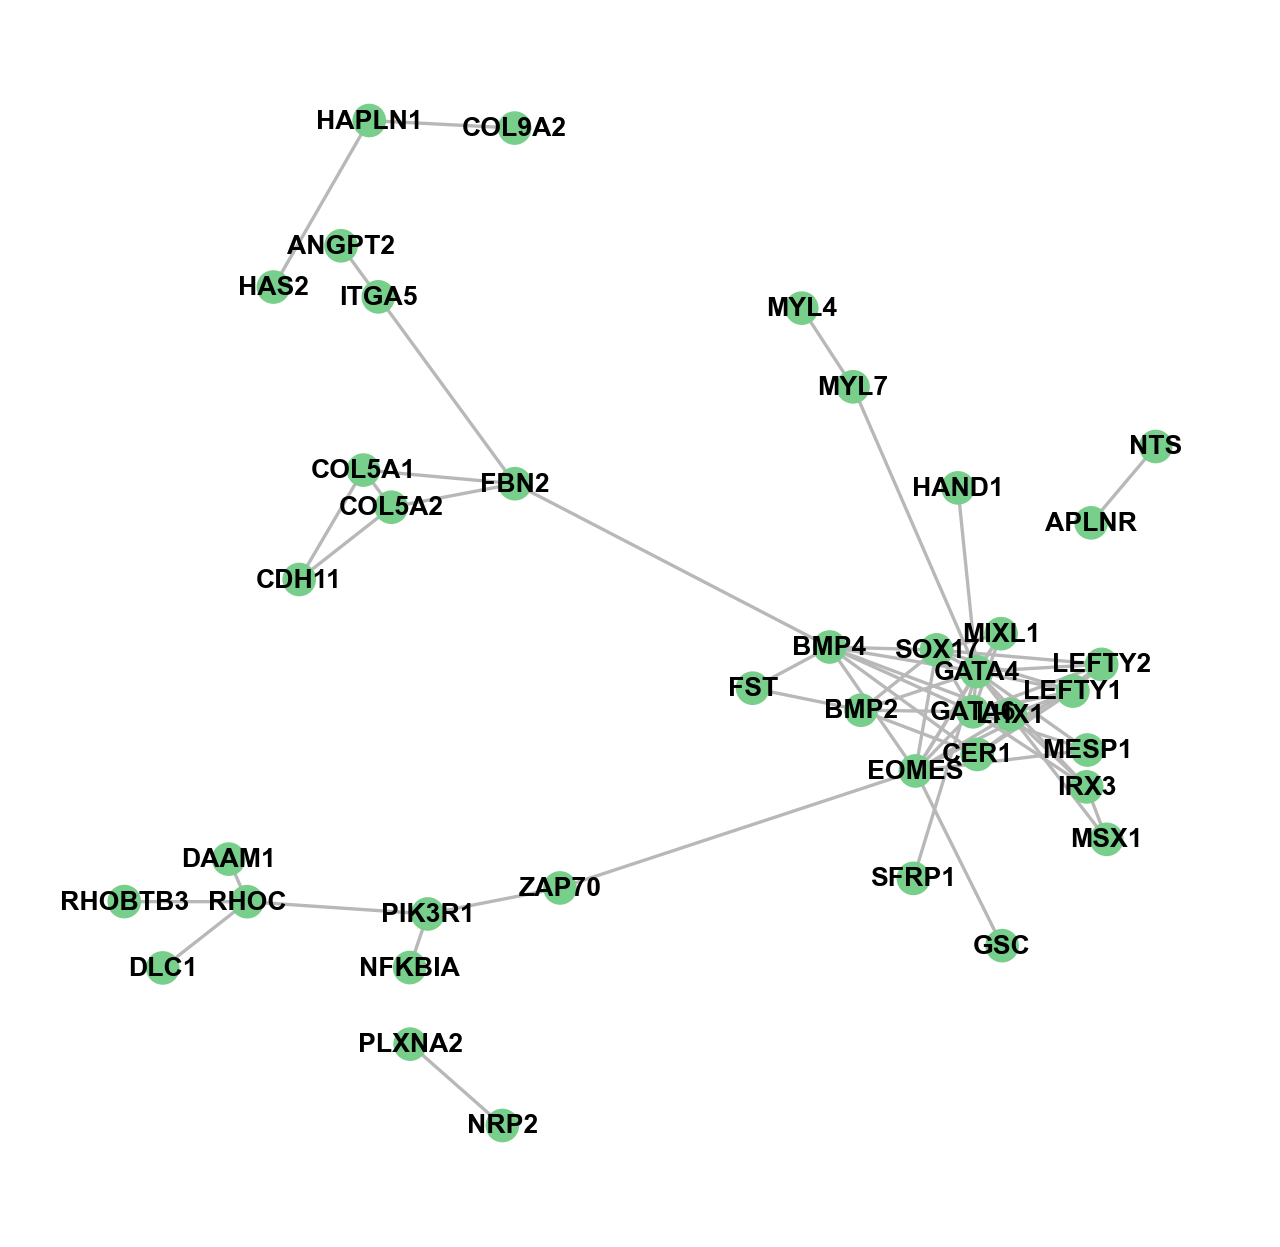

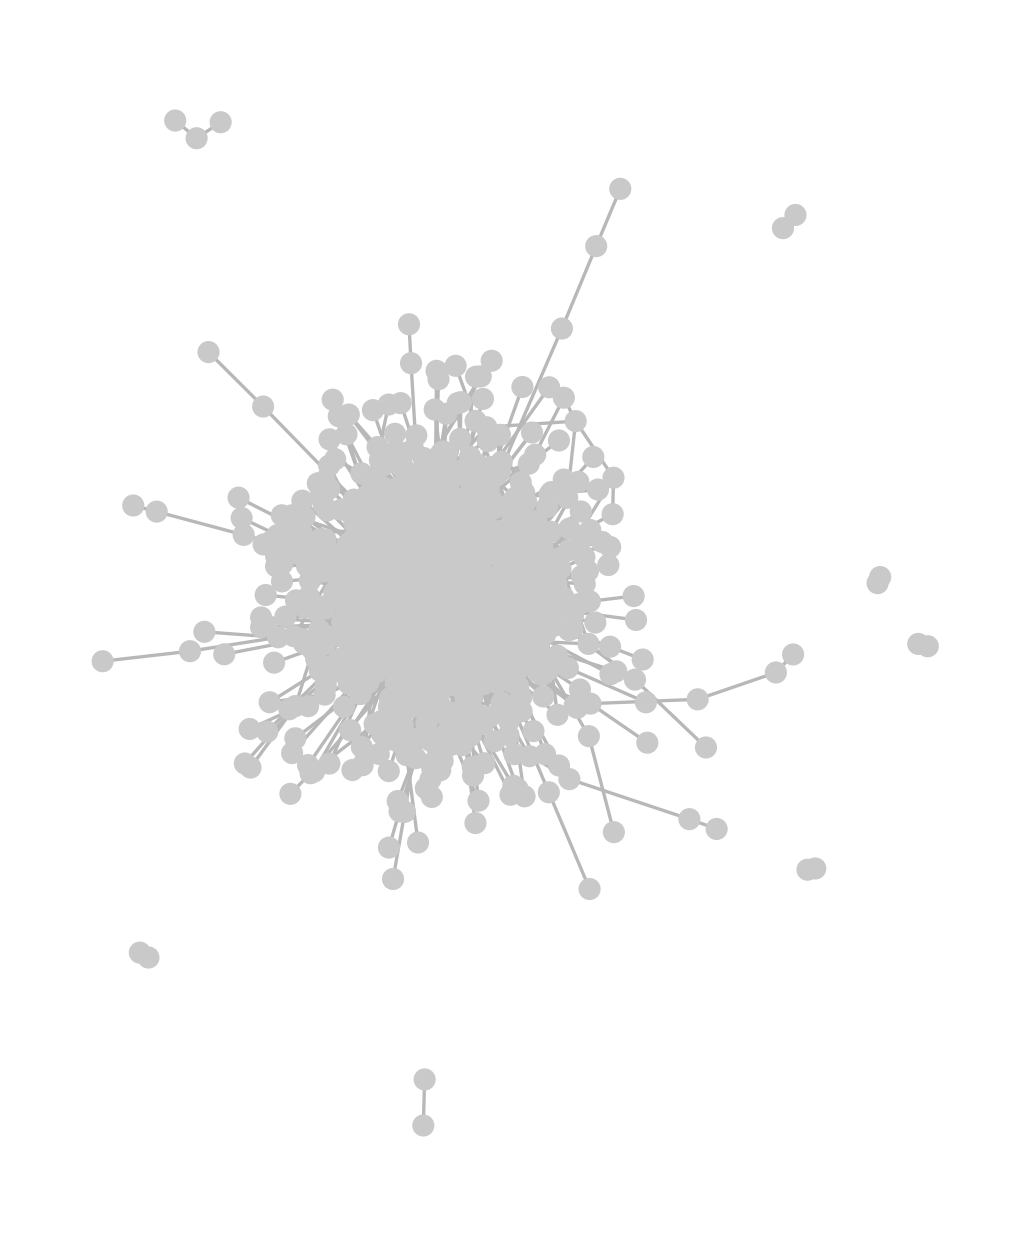

In [5]:
#plot DELVE modules
string_directory = os.path.join('../figures', 'DE', 'STRING_runner')
module_id = 'dynamic 0'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B'}, 
                                module_id = module_id, figsize = (10,10), node_size = 200, font_size = '12', with_labels = True, species = '9606', 
                                save_directory = string_directory, filename_save = module_id.replace(' ', '_'))

module_id = 'dynamic 1'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B'}, 
                                module_id = module_id, figsize = (10,10), node_size = 200, font_size = '12', with_labels = True, species = '9606',
                                save_directory = string_directory, filename_save = module_id.replace(' ', '_'))

module_id = 'static'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B'}, 
                                module_id = module_id, figsize = (8,10), node_size = 80, font_size = '10', with_labels = False, species = '9606',
                                save_directory = string_directory, filename_save = module_id)

#### Perform a permutation test to assess the significance of experimentally-derived edges within DELVE modules as compared to random feature-cluster assignment


dynamic 0
dynamic 1
static


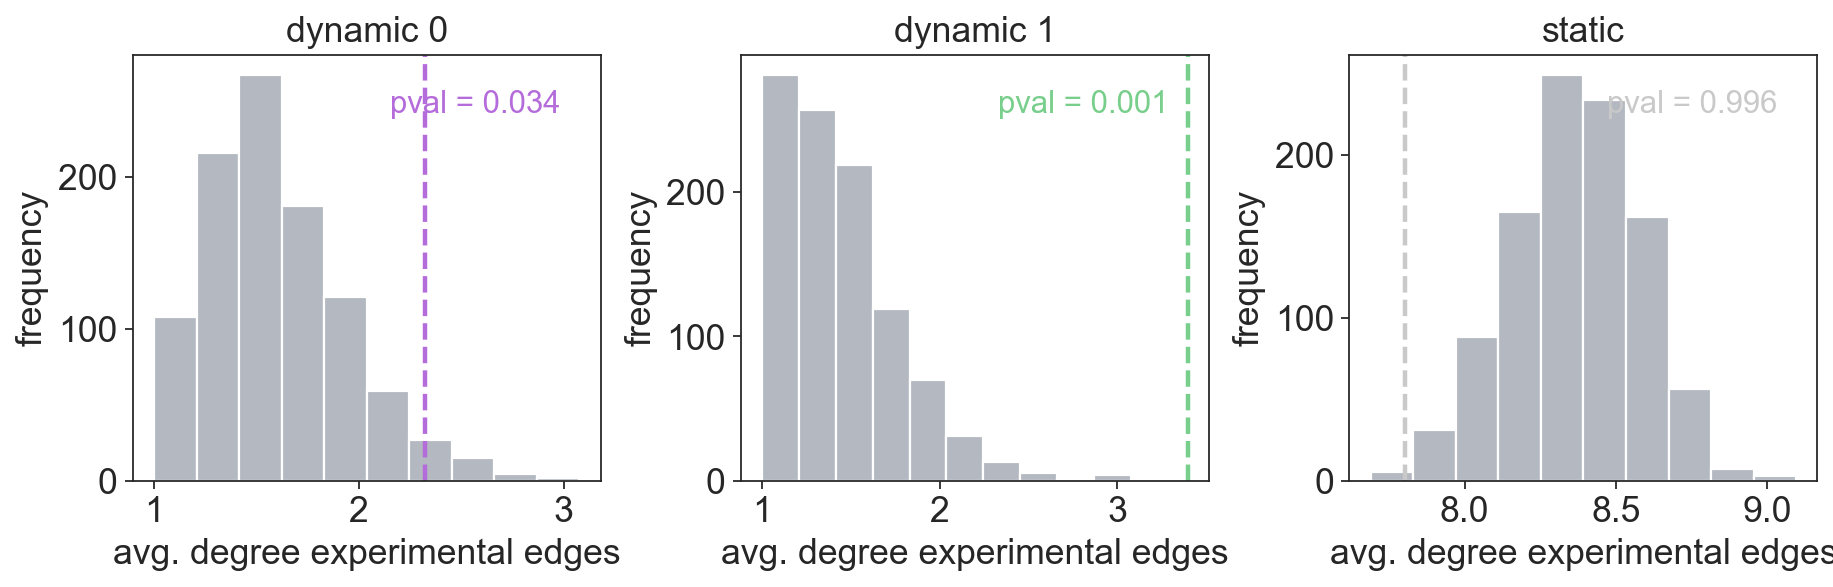

In [6]:
### note this takes a while to run
obs_df, rand_df = delve_benchmark.tl.permute_string(modules = modules, niterations= 1000, colors = ['#B46CDA', '#78CE8B', '#C9C9C9'], species = '9606', save_directory = string_directory)

### Compare trajectory inference performance: DELVE, HVG, Hotspot, Laplacian score, RNA velocity

#### Perform feature selection using the alternative methods

In [7]:
# HVG
fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.hvg, fs_method_params = {'n_top_genes': n_selected, 'log': False})
hvg_genes = fs.select()
hvg_genes.to_csv(os.path.join(feature_directory, 'hvg.csv'))
hvg_genes = hvg_genes.index

# RNA velocity
RNA_velocity_genes = pd.DataFrame(adata.var['fit_likelihood'][~adata.var['fit_likelihood'].isnull()])
RNA_velocity_genes.to_csv(os.path.join(feature_directory, 'rna_velocity_fs.csv'))
RNA_velocity_genes = RNA_velocity_genes.sort_values(by = 'fit_likelihood', ascending = False).index[:n_selected]

#### Perform trajectory inference on selected feature set and regression analysis to identify significant dynamically expressed genes

INFO:root:estimating diffusion pseudotime using DELVE genes
INFO:root:root cell 2591


Calculating PHATE...
  Running PHATE on 5397 cells and 500 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.87 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 2.18 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.76 seconds.
  Calculated landmark operator in 5.55 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.60 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 21.62 seconds.
Calculated PHATE in 29.95 seconds.


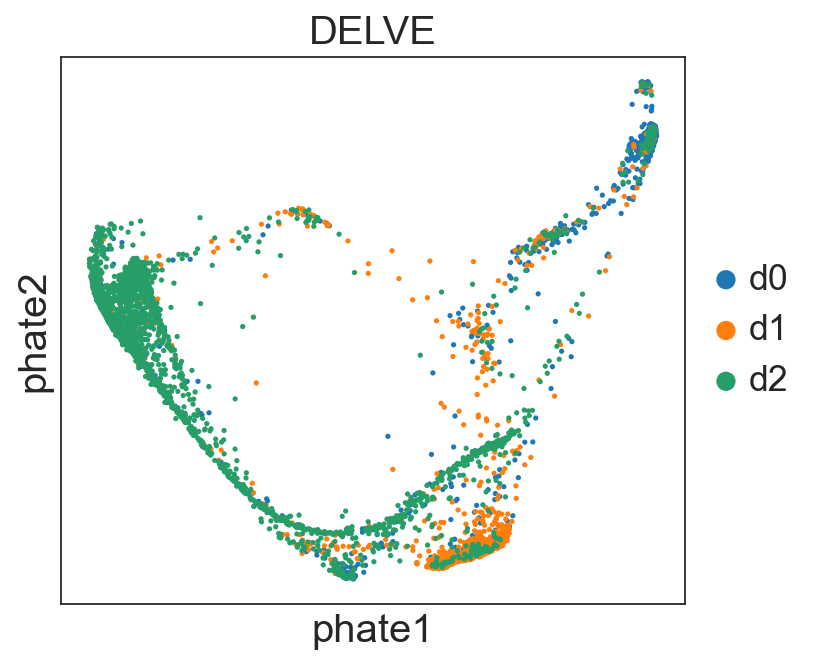

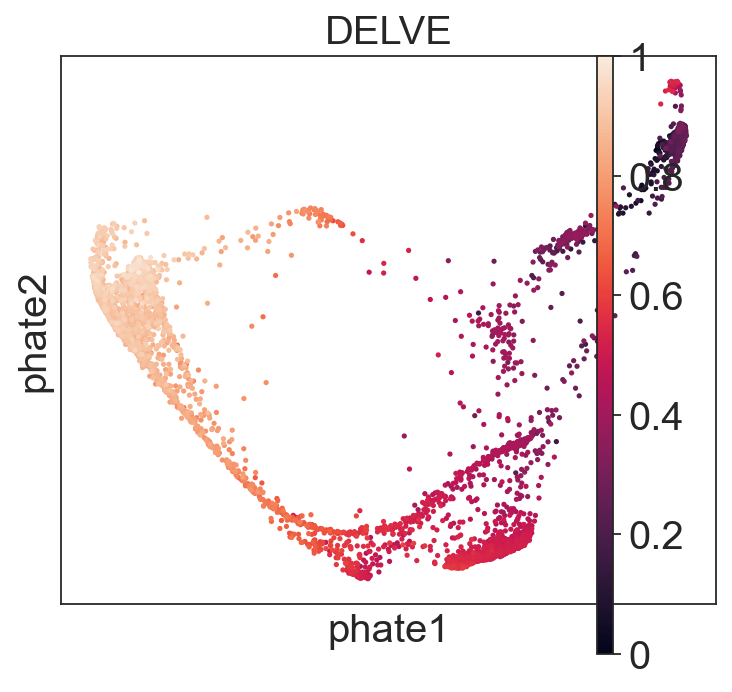

INFO:root:root cell 4900
INFO:root:root cell 97
INFO:root:root cell 319
INFO:root:root cell 1683
INFO:root:root cell 5134
INFO:root:root cell 1811
INFO:root:root cell 4490
INFO:root:root cell 5011
INFO:root:root cell 3777
INFO:root:estimating diffusion pseudotime using HVG genes
INFO:root:root cell 2591


Calculating PHATE...
  Running PHATE on 5397 cells and 500 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.98 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 2.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.79 seconds.
  Calculated landmark operator in 6.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.71 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 15.11 seconds.
Calculated PHATE in 24.71 seconds.


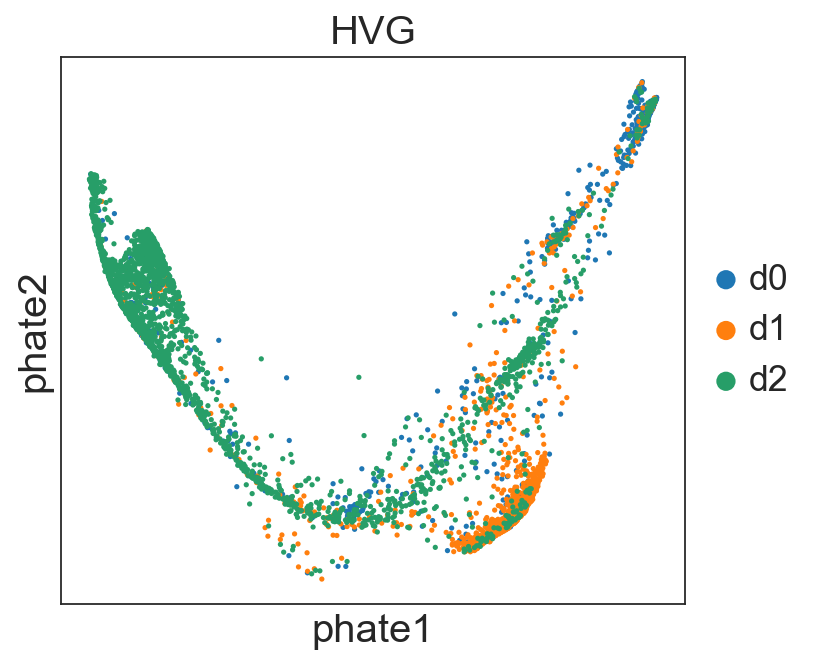

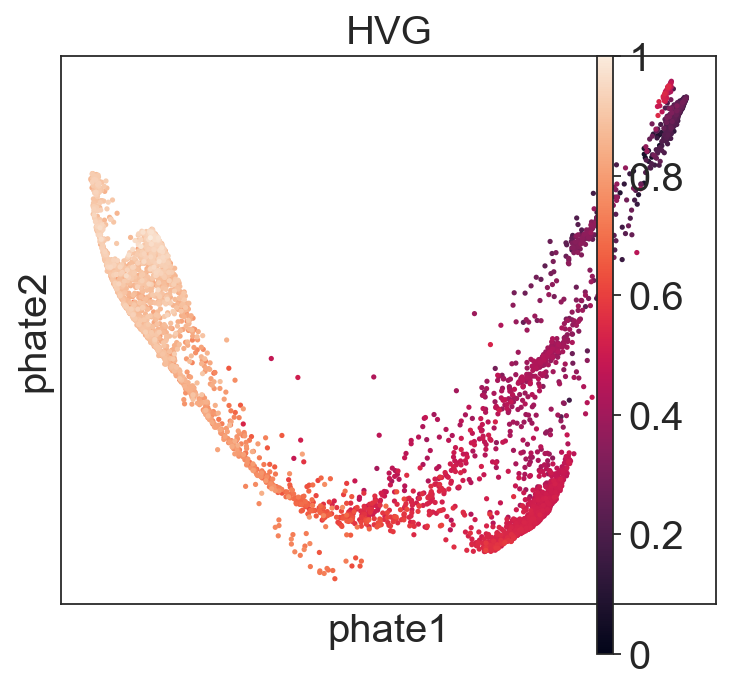

INFO:root:root cell 4900
INFO:root:root cell 97
INFO:root:root cell 319
INFO:root:root cell 1683
INFO:root:root cell 5134
INFO:root:root cell 1811
INFO:root:root cell 4490
INFO:root:root cell 5011
INFO:root:root cell 3777
INFO:root:estimating diffusion pseudotime using RNA velocity genes
INFO:root:root cell 2591


Calculating PHATE...
  Running PHATE on 5397 cells and 500 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.19 seconds.
    Calculating affinities...
    Calculated affinities in 0.47 seconds.
  Calculated graph and diffusion operator in 3.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.90 seconds.
  Calculated landmark operator in 7.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.92 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.41 seconds.
Calculated PHATE in 21.13 seconds.


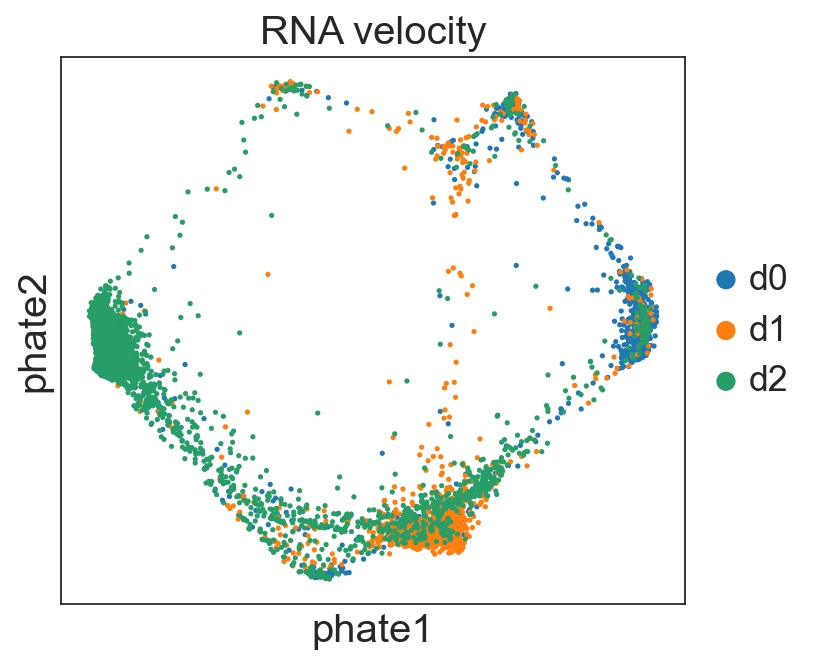

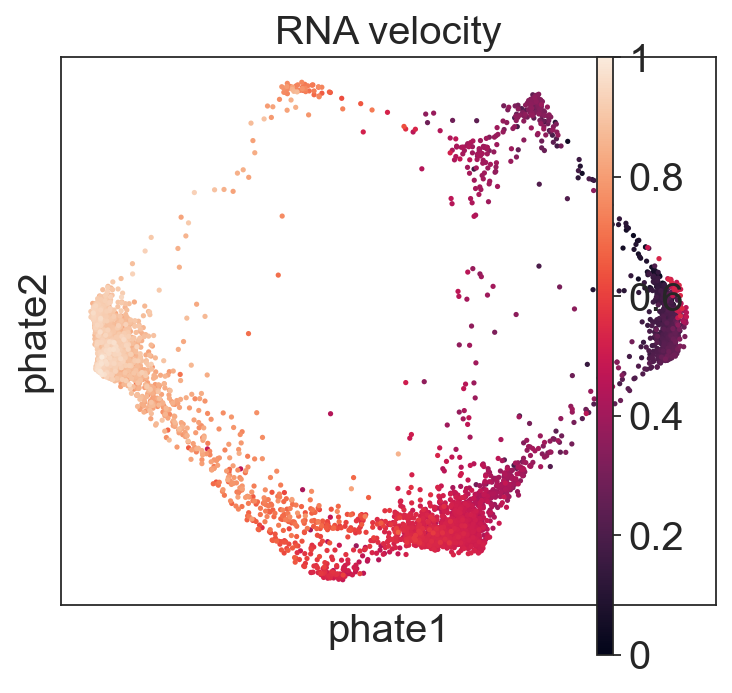

INFO:root:root cell 4900
INFO:root:root cell 97
INFO:root:root cell 319
INFO:root:root cell 1683
INFO:root:root cell 5134
INFO:root:root cell 1811
INFO:root:root cell 4490
INFO:root:root cell 5011
INFO:root:root cell 3777


In [8]:
gene_lists = [list(delve_genes),
              list(hvg_genes),
              list(RNA_velocity_genes)]

titles = ['DELVE', 'HVG', 'RNA velocity']

root_cells = [2591, 4900, 97, 319, 1683, 5134, 1811, 4490, 5011, 3777] #np.random.choice(np.where(np.isin(adata.obs['day'], 'd0'))[0], 10)
de_gene_lists_all = []
for i in range(0, len(gene_lists)):
    de_gene_lists = pd.DataFrame()
    logging.info(f'estimating diffusion pseudotime using {titles[i]} genes')
    for j in range(0, len(root_cells)):     
        #subset adata according to selected features
        adata_run = adata.copy()
        adata_run = adata_run[:, np.isin(adata_run.var_names, gene_lists[i])].copy()

        #obtain root cell for trajectory inference        
        root_cell = root_cells[j]
        logging.info(f'root cell {root_cell}')

        #perform trajectory inference and regression analysis to find significant dynamically expressed genes
        adata_run, de_df = delve_benchmark.tl.compute_de(adata = adata_run, de_method = delve_benchmark.tl.perform_dpt, de_params = {'k': 10, 'n_pcs': 50, 'n_dcs': 20, 'root': root_cell})
        
        #plot trajectory
        if j == 0: #save the first for visual representation
            op = phate.PHATE(knn = k, t = 30, random_state = 0)
            X_phate = op.fit_transform(adata_run)
            adata_run.obsm['X_phate'] = X_phate.copy()

            fig, ax = plt.subplots(figsize = (5, 4.5),  gridspec_kw={'hspace': 0.45, 'wspace': 0.4})
            sc.pl.scatter(adata_run, basis = 'phate', title = titles[i], color = 'day', ax = ax, legend_fontsize=16)
            fig, ax = plt.subplots(figsize = (5.25,4.5))
            sc.pl.scatter(adata_run, basis = 'phate', title = titles[i], color = 'dpt_pseudotime', ax = ax, legend_fontsize=16)
        
        de_df.columns = [root_cell]
        de_gene_lists = pd.concat([de_gene_lists, de_df], axis = 1)
    de_gene_lists_all.append(de_gene_lists)

#### Perform gene set enrichment analysis using [Enrichr](https://gseapy.readthedocs.io/en/latest/introduction.html)

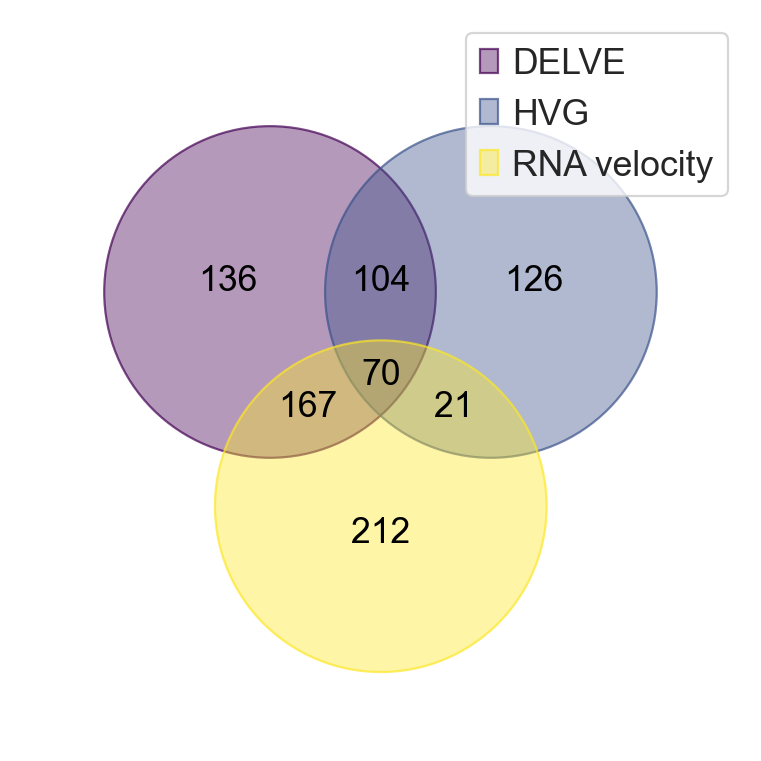

In [9]:
## plot overlapping genes
colors = delve_benchmark.pl.generate_colors(cmap="viridis", n_colors = 5, alpha = 0.4)

for root_cell in [root_cells[0]]: #only showing the first for visual representation
    delve_genes_pst = de_gene_lists_all[0].loc[:, root_cell][~de_gene_lists_all[0].loc[:, root_cell].isna()].sort_values(ascending = True).index
    hvg_genes_pst = de_gene_lists_all[1].loc[:, root_cell][~de_gene_lists_all[1].loc[:, root_cell].isna()].sort_values(ascending = True).index
    rna_velocity_genes_pst = de_gene_lists_all[2].loc[:, root_cell][~de_gene_lists_all[2].loc[:, root_cell].isna()].sort_values(ascending = True).index

    # DELVE vs. HVG vs. RNA velocity
    fig, axes = plt.subplots(1, 1, figsize = (6,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.3, 'bottom':0.15})
    feature_list = {"DELVE": set(delve_genes_pst),
                "HVG": set(hvg_genes_pst),
                "RNA velocity": set(rna_velocity_genes_pst)}

    g = venn(feature_list, fontsize=16, cmap = colors[:2]+[colors[-1]], ax = axes, legend_loc="upper right")
    plt.show()

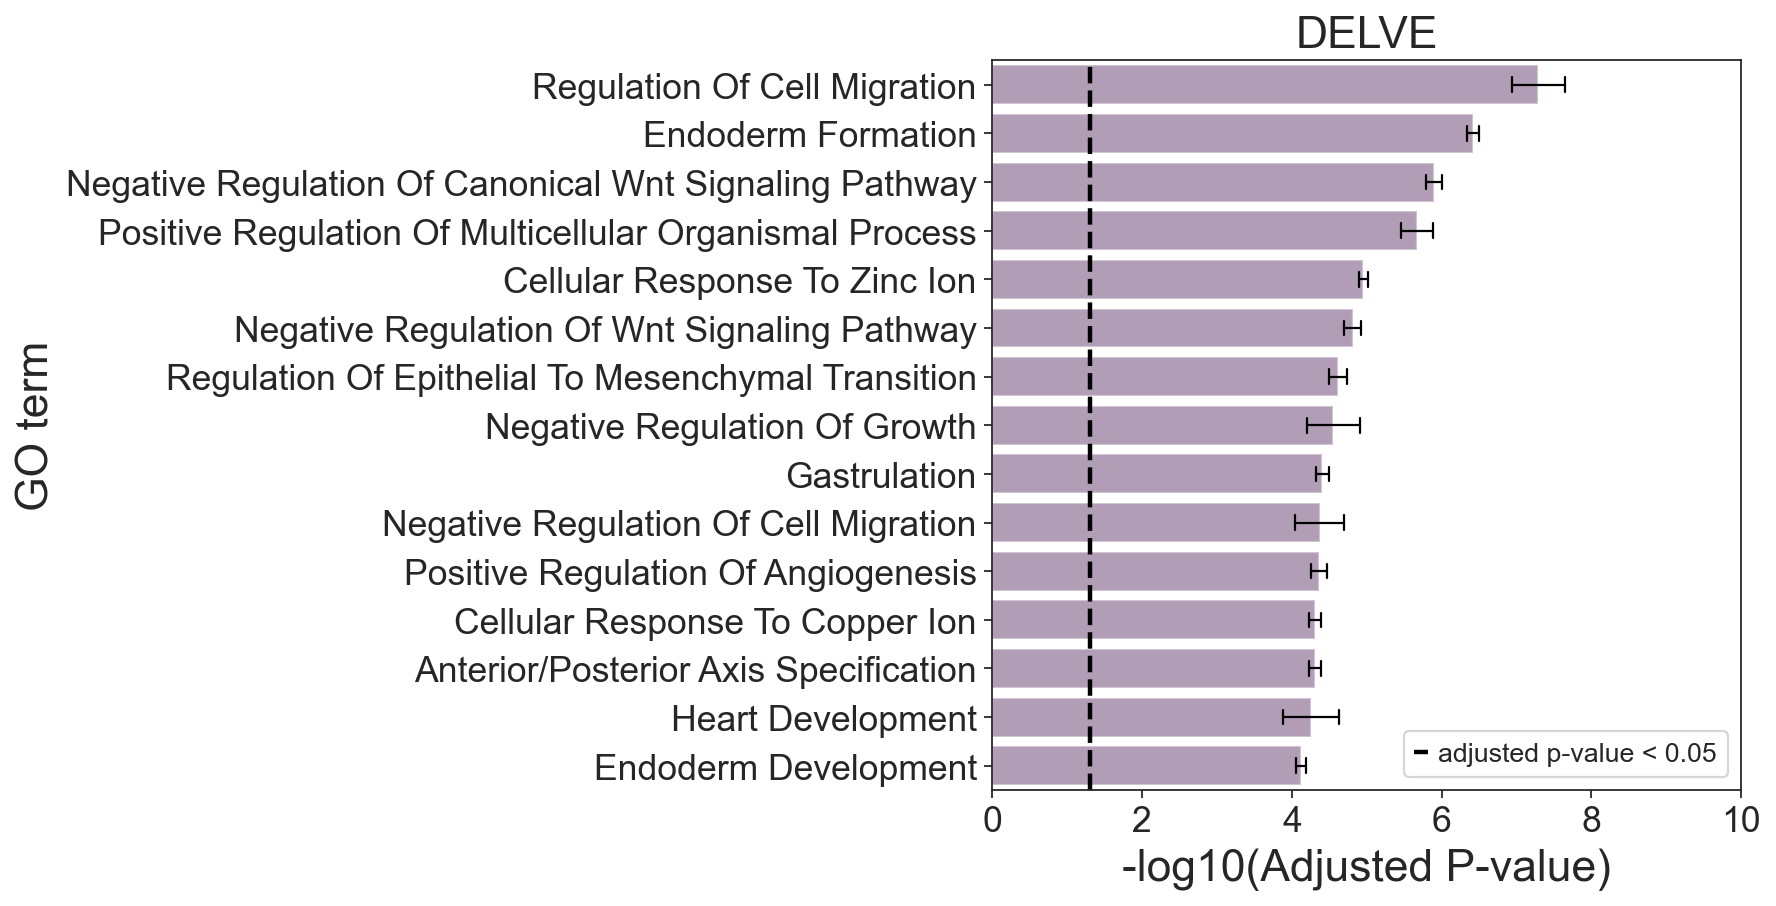

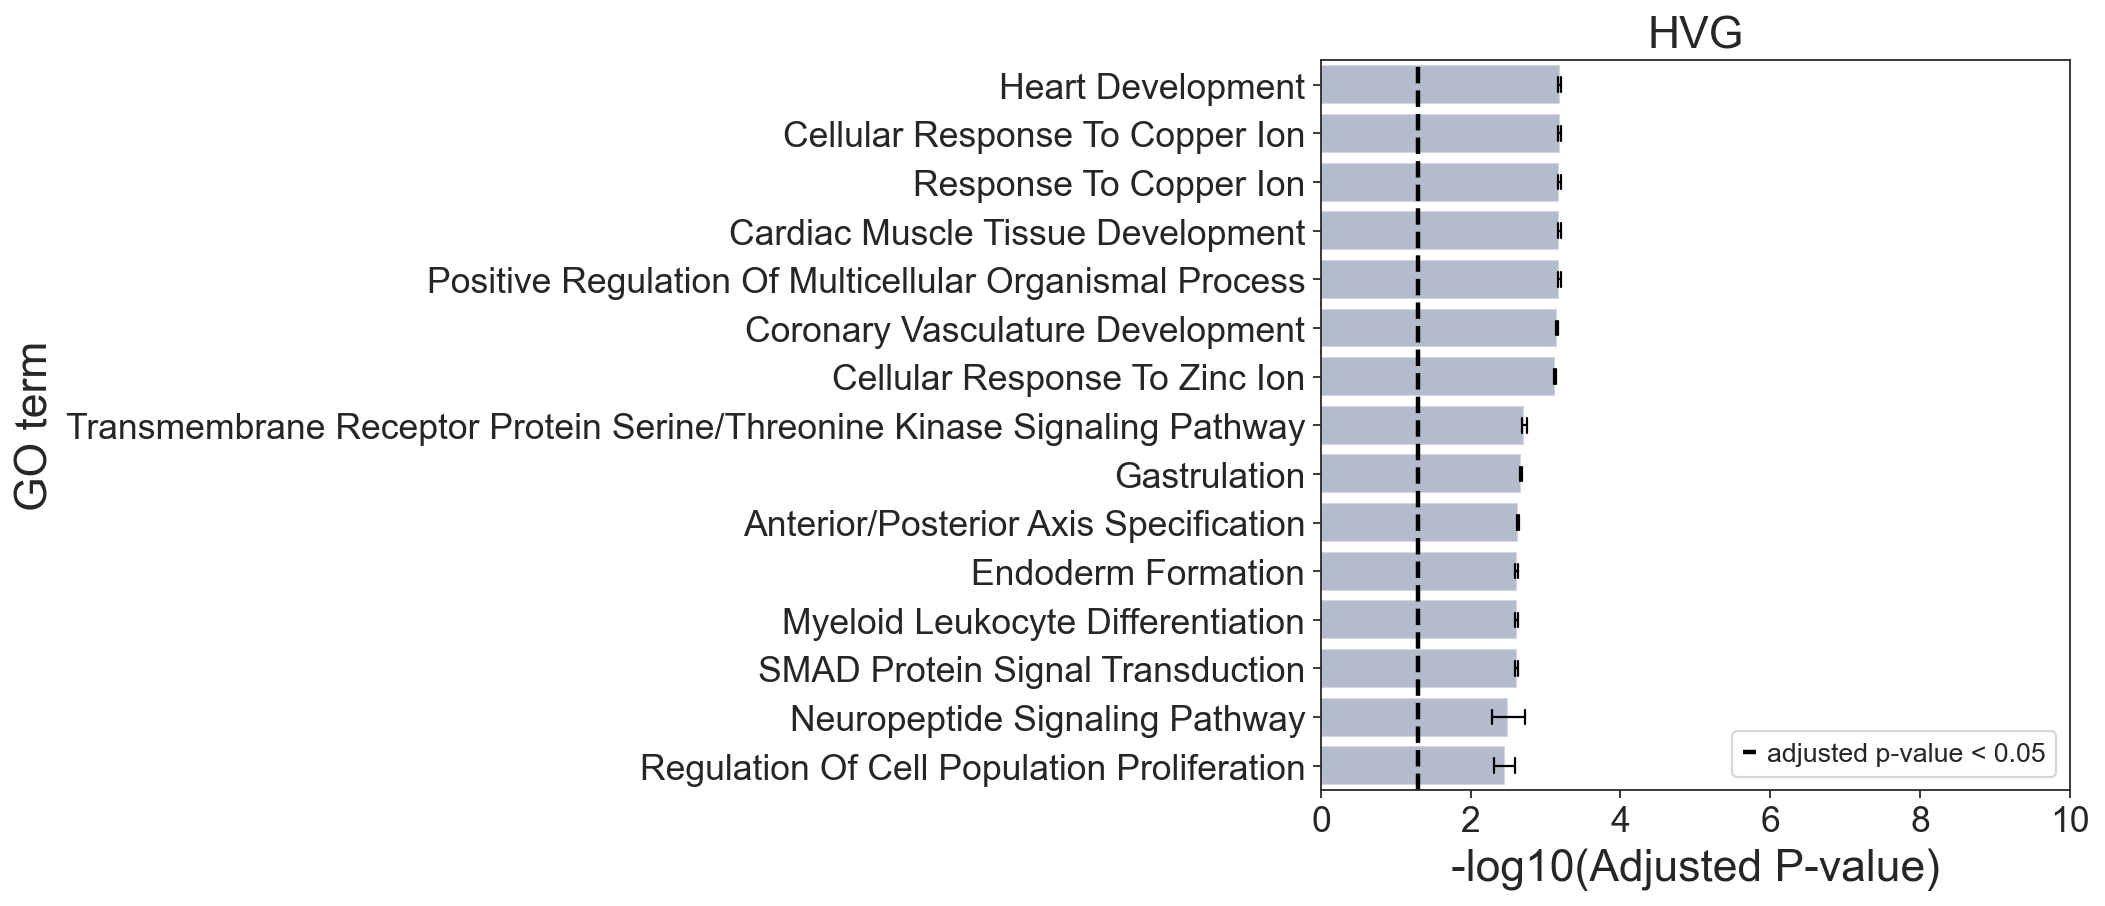

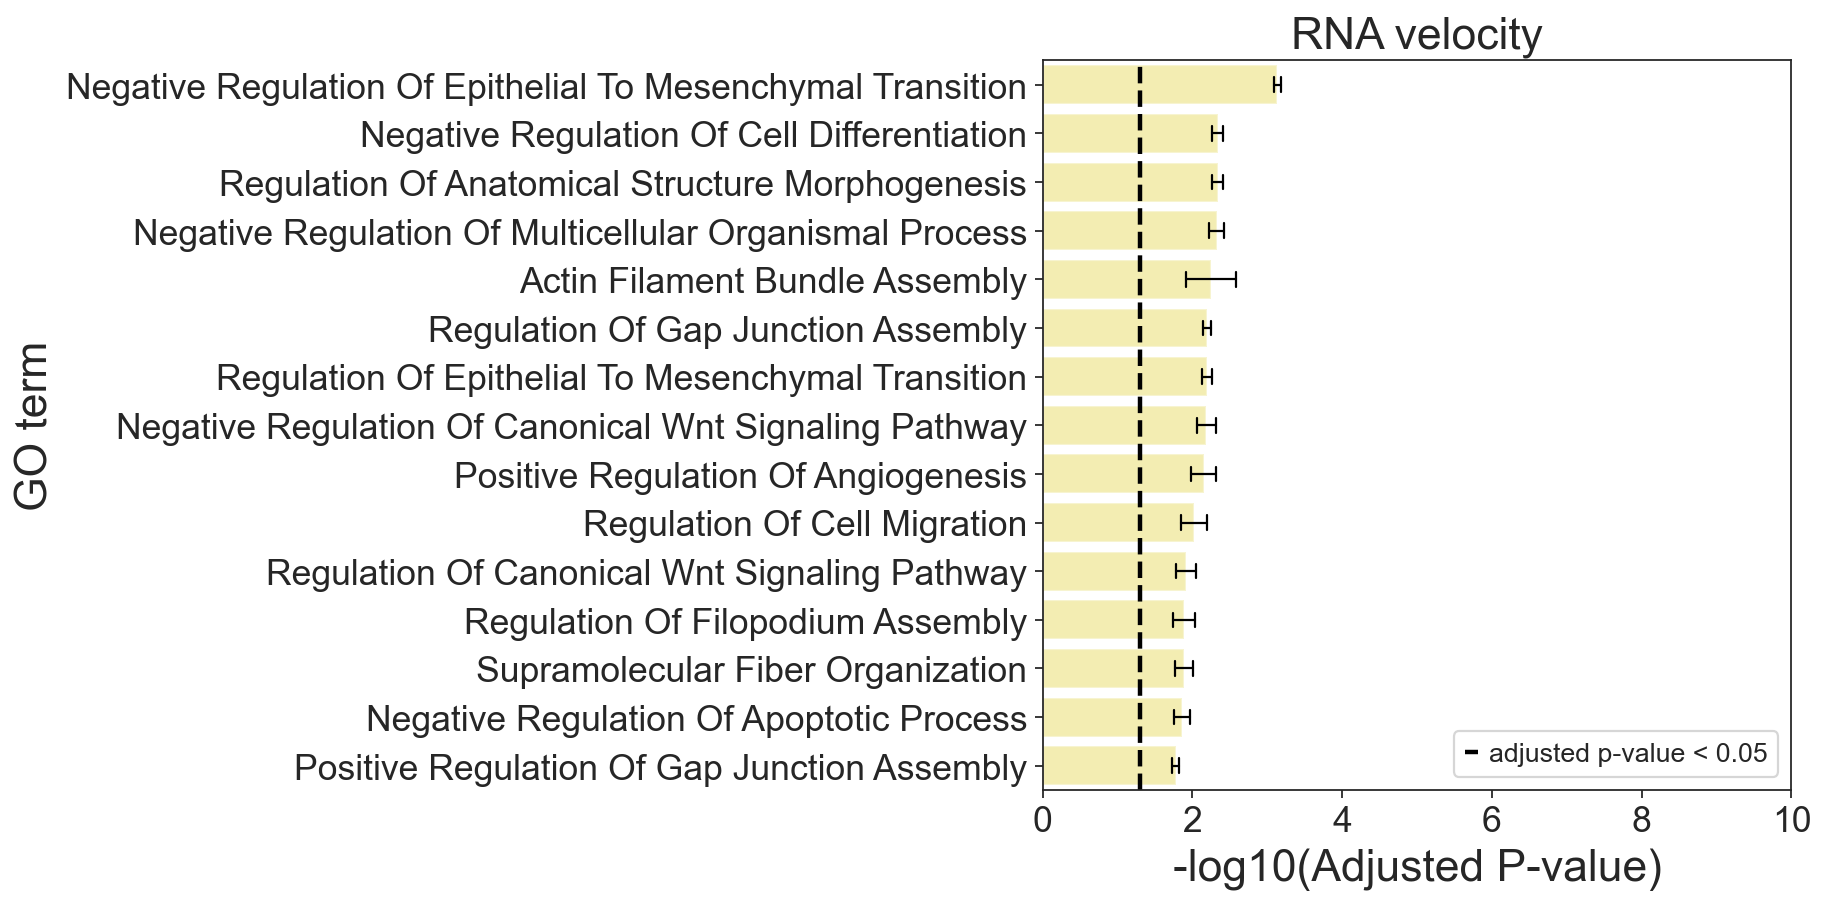

In [10]:
## plot gene ontology scores
gene_sets = ['GO_Biological_Process_2023']
organism = 'human'
xlim = [0, 10]

## DELVE
delve_benchmark.pl.plot_GO(de_gene_lists_all[0], gene_sets = gene_sets, organism = organism, xlim = xlim,sig_cutoff= 0.05, color = colors[0], save_directory = None, filename_save = titles[0])
## HVG
delve_benchmark.pl.plot_GO(de_gene_lists_all[1], gene_sets = gene_sets, organism = organism, xlim = xlim, sig_cutoff= 0.05, color = colors[1], save_directory = None, filename_save = titles[1])
## RNA velocity
delve_benchmark.pl.plot_GO(de_gene_lists_all[2], gene_sets = gene_sets, organism = organism, xlim = xlim, sig_cutoff= 0.05, color = colors[4], save_directory = None, filename_save = titles[2])

### Plot delve dynamic module genes ordered by estimated pseudotime 

In [11]:
adata_pst = adata.copy()
adata_pst = adata_pst[:, np.isin(adata_pst.var_names, delve_genes)].copy()
adata_pst, de_df = delve_benchmark.tl.compute_de(adata = adata_pst, de_method=delve_benchmark.tl.perform_dpt, de_params={'k': 10, 'n_pcs': 50, 'n_dcs': 20, 'root': root_cells[0]})

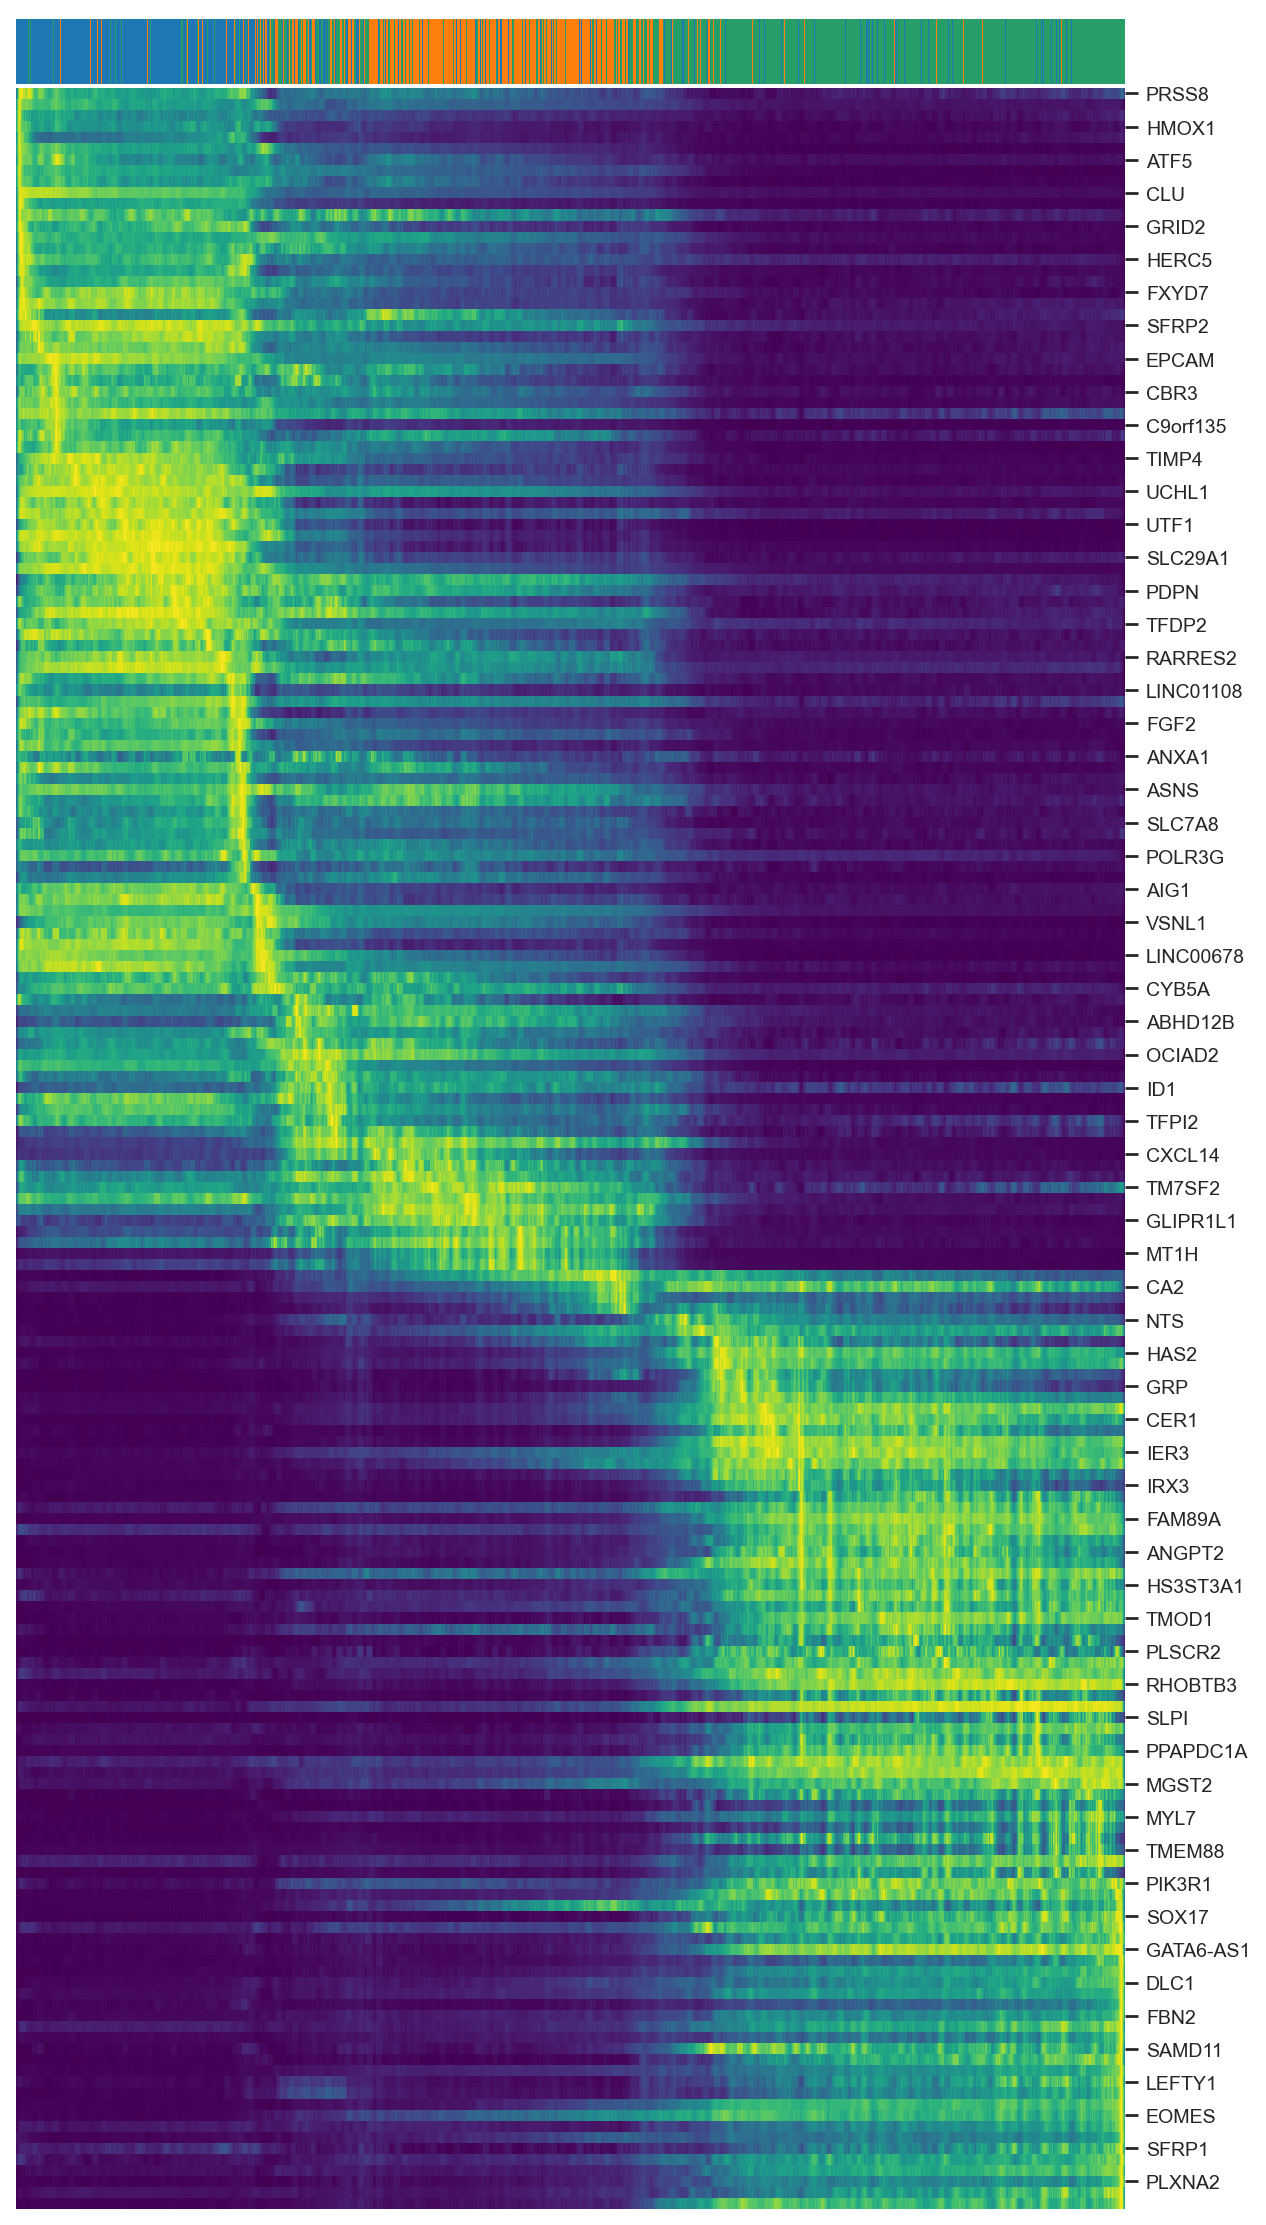

In [12]:
set_diff = list(modules[modules['cluster_id'] != 'static'].index)
scv.pl.heatmap(adata_pst, var_names = set_diff, sortby='dpt_pseudotime', figsize = (8, 14), col_color = 'day', font_scale=0.8)

### Compare transcription factors following trajectory inference with for each feature selection approach

In [13]:
#load the data
tf_data = pd.read_csv(os.path.join('../data', 'Homo_sapiens_TF.txt'), sep="\t", header=0) ##https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6323978/
tf_list = tf_data[~tf_data['Symbol'].isna()]['Symbol'].values

n_tf = pd.DataFrame()
for root_cell in root_cells: #only showing the first for visual representation
    delve_genes_pst = de_gene_lists_all[0].loc[:, root_cell][~de_gene_lists_all[0].loc[:, root_cell].isna()].sort_values(ascending = True).index
    hvg_genes_pst = de_gene_lists_all[1].loc[:, root_cell][~de_gene_lists_all[1].loc[:, root_cell].isna()].sort_values(ascending = True).index
    rna_velocity_genes_pst = de_gene_lists_all[2].loc[:, root_cell][~de_gene_lists_all[2].loc[:, root_cell].isna()].sort_values(ascending = True).index

    n_tf_ = pd.DataFrame([len(set(delve_genes_pst).intersection(set(tf_list))),
                len(set(tf_list).intersection(set(hvg_genes_pst))),
                len(set(tf_list).intersection(set(rna_velocity_genes_pst)))], index = ['DELVE', 'HVG', 'RNA_velocity'])
    n_tf = pd.concat([n_tf, n_tf_.transpose()], axis = 0)    

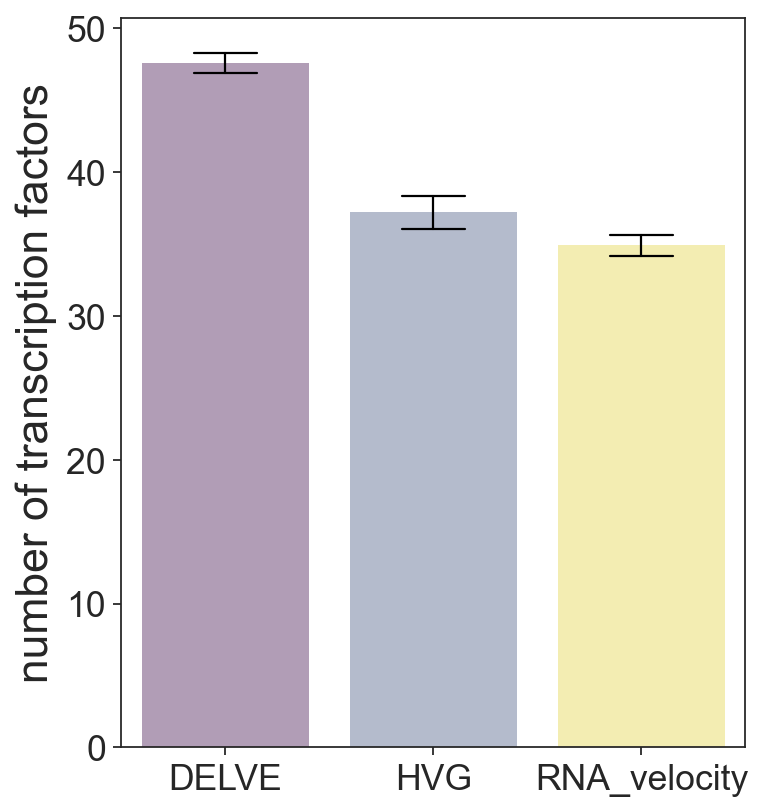

In [14]:
#plot the number of transcription factors following trajectory inference with for each feature selection approach 
fig, axes = plt.subplots(1, 1, figsize = (5,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.3, 'bottom':0.15})
g = sns.barplot(x = 'variable', y = 'value', data = n_tf.melt(), palette = [colors[0], colors[1], colors[4]],
                alpha = 0.4, estimator=np.mean, lw = 0., ax = axes, ci = 'sd',
                capsize = 0.3, errcolor = 'black', errwidth=1)
g.tick_params(labelsize=16)
g.set_xlabel('', fontsize = 20)
g.set_ylabel('number of transcription factors', fontsize = 20)
plt.show()

In [15]:
set(delve_genes_pst).intersection(set(tf_list)).difference(set(rna_velocity_genes_pst))

{'CDX1',
 'CDX2',
 'DDIT3',
 'EOMES',
 'FOXA2',
 'GSC',
 'HAND1',
 'HES1',
 'HLX',
 'ID1',
 'ID3',
 'LHX1',
 'MESP1',
 'MESP2',
 'MSX1',
 'MXD4',
 'NR0B1',
 'OTX2',
 'PITX1',
 'POU5F1',
 'SALL2',
 'SAMD11',
 'SHOX2',
 'SOX15',
 'SOX17',
 'SOX2',
 'SP5',
 'SPIB',
 'TBX3',
 'ZSCAN10'}

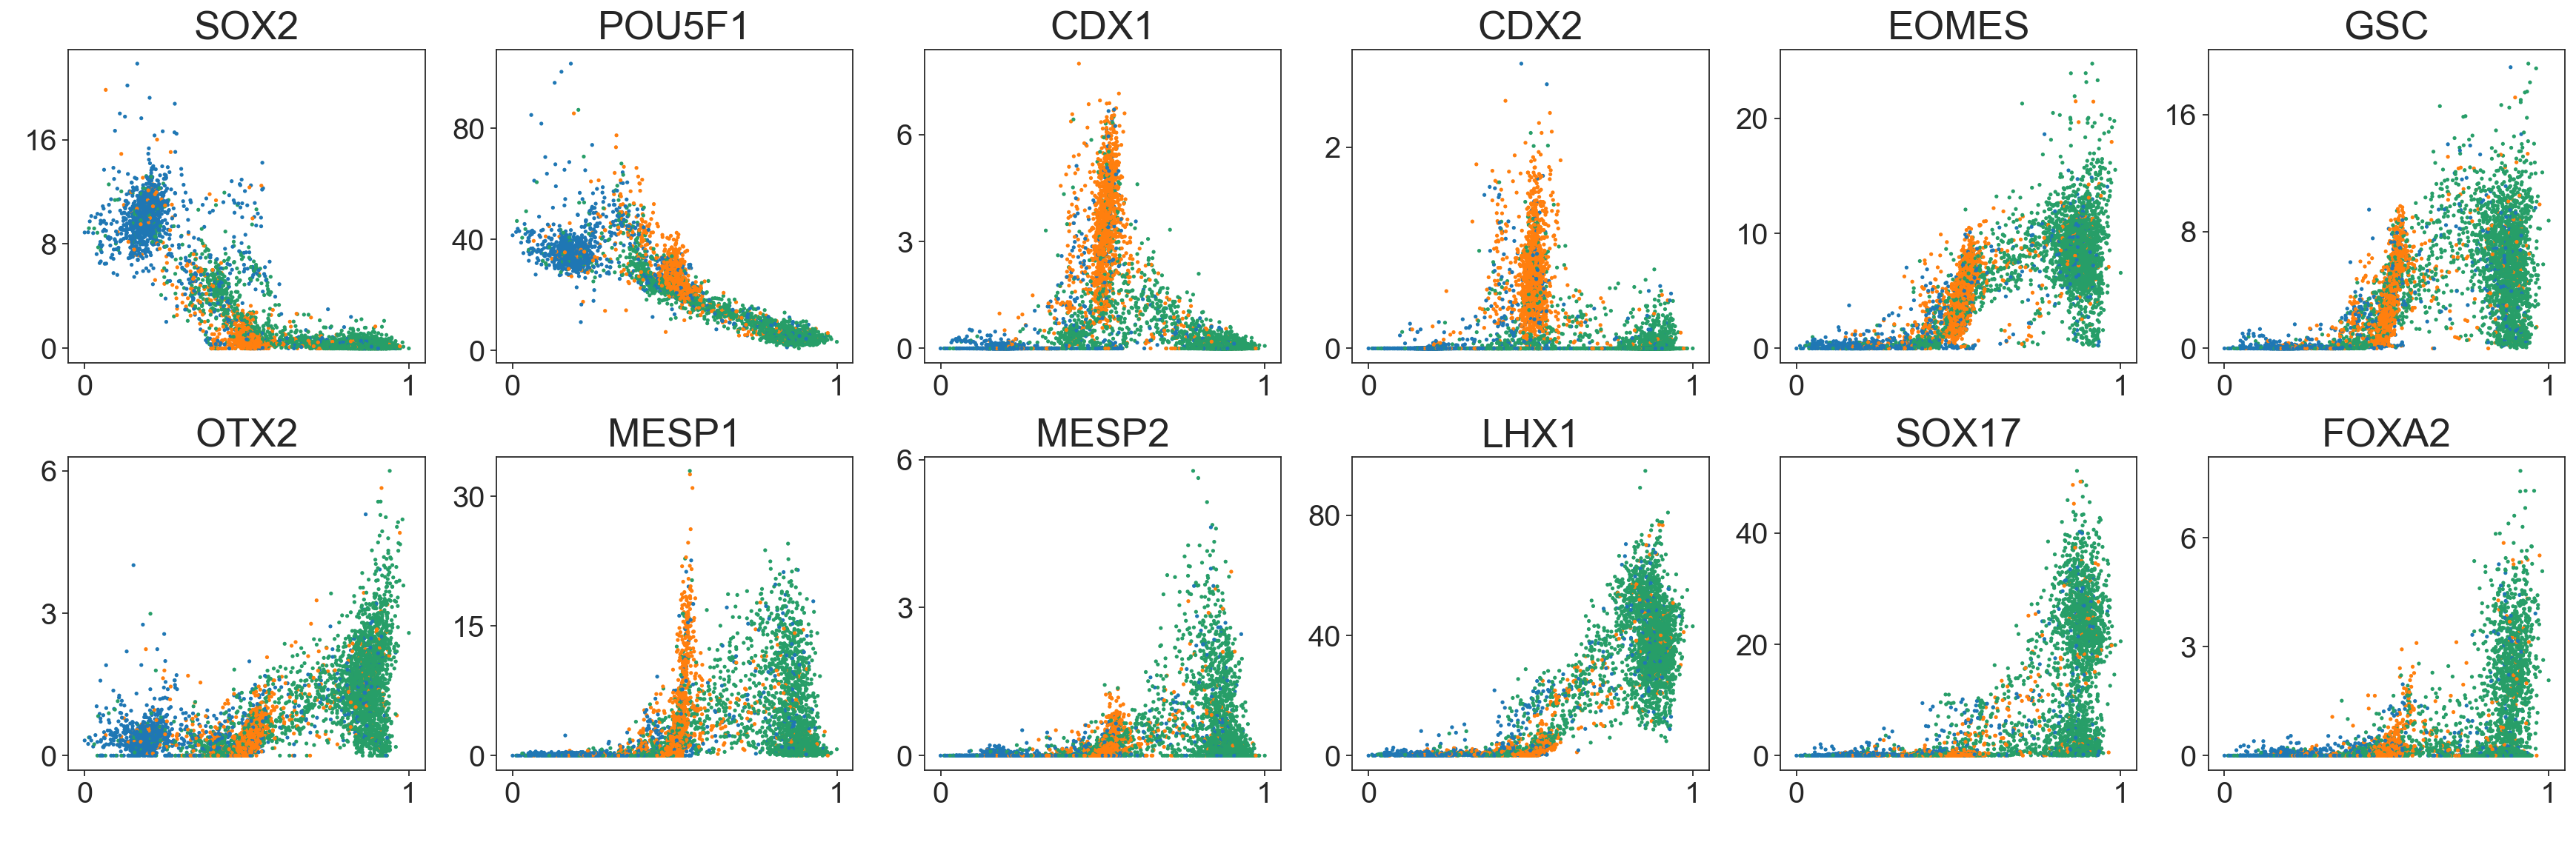

In [16]:
#plot time traces of defintive endoderm regulators identified by DELVE and missed by RNA velocity
scv.pl.scatter(adata_pst, x='dpt_pseudotime', y=['SOX2', 'POU5F1', 'CDX1', 'CDX2', 'EOMES', 'GSC', 'OTX2', 'MESP1', 'MESP2', 'LHX1', 'SOX17', 'FOXA2'], ncols = 6, color = 'barcode_groups', xlabel = ' ',ylabel = ' ', fontsize=24, figsize = (4.5, 4))